### Setup

In [3]:
import os, sys
HOME = os.environ['HOME']  # change if necessary
sys.path.append(f'{HOME}/Finite-groups/src')

In [4]:
import torch as t
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
from jaxtyping import Float
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
import math
from itertools import product
import pandas as pd
from typing import Union
from einops import repeat
from huggingface_hub import snapshot_download
from huggingface_hub.utils import disable_progress_bars


from model import MLP3, MLP4, InstancedModule
from utils import *
from group_data import *
from model_utils import *
from group_utils import *
%load_ext autoreload
%autoreload 2

Syntax warning: Unbound global variable in /usr/share/gap/pkg/browse/PackageIn\
fo.g:73
  if not IsKernelExtensionAvailable("Browse", "ncurses") then
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
Syntax warning: Unbound global variable in /usr/share/gap/pkg/edim/PackageInfo\
.g:60
  if not IsKernelExtensionAvailable("EDIM","ediv") then
         ^^^^^^^^^^^^^^^^^^^^^^^^^^


In [5]:
MODEL_DIR = '2024-08-16_22-53-29_SL2_5_MLP3_256'
disable_progress_bars()
local_dir = f'{HOME}/models/{MODEL_DIR}'
snapshot_download(repo_id=f'wiwu2390/{MODEL_DIR}', local_dir=local_dir)
models, params = load_models(local_dir)
data = GroupData(params)
group = data.groups[0]

Intersection size: 14400/14400 (1.00)
Added 14400 elements from intersection
Added 0 elements from group 0: smallgrp(120, 5)
Taking random subset: 5760/14400 (0.40)
Train set size: 5760/14400 (0.40)


/home/wilson/Finite-groups/src/model_utils.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(model_path, map_location=device))


`models` (returned from `load_models`) is a list of InstancedModule objects, one for each training checkpoint that we chose to save. For most runs, we only save the final checkpoints, so `len(models)==1`

For efficiency during training, the InstancedModule object contains 100 different instances starting from different random initializations. 

Here, we look only at the one with best test accuracy.

In [6]:
loss_dict = test_loss(models[-1].to(device), data)
print(loss_dict['G0_loss'].min(), loss_dict['G0_loss'].argmin())
instance = loss_dict['G0_loss'].argmin().item()
model = models[-1][instance].to(device)

tensor(0.0567) tensor(19)


"MLP3" architecture is
$$f(z\mid x, y) = W_u(z)\cdot\text{ReLU}[W_h(W_l(x)+W_r(y))]] = \sum_i w_u^i(z) \text{ReLU}[w_l^i(x)+w_r^i(y)]$$
where $w_u^i, w_l^i, w_r^i\in\mathbb{R}^G$ are the columns of $W_u, (W_hW_l)^{\top}, (W_hW_r)^{\top}$ respectively.

In [24]:
lneurons, rneurons = model.get_neurons()
uneurons = model.unembedding.data.detach()
lneurons, rneurons, uneurons = lneurons.squeeze(0).to('cpu'), rneurons.squeeze(0).to('cpu'), uneurons.squeeze(0).to('cpu').T
lneurons.shape, rneurons.shape, uneurons.shape

(torch.Size([120, 256]), torch.Size([120, 256]), torch.Size([120, 256]))

### Observation 0: Neurons are irrep-sparse

I.e., each neuron is a linear combination of matrix entries of some irrep.

That is, for each $i$, there exists an irrep $\rho_i\colon G\to\text{GL}(\mathbb{R}^d)$ such that, for some $A_i,B_i,C_i$,
$$w_l^i(x) \approx \text{tr}(\rho_i(x) A_i)$$
$$w_r^i(y) \approx \text{tr}(\rho_i(y) B_i)$$
$$w_u^i(z) \approx \text{tr}(\rho_i(z) C_i)$$

(This was first noticed by Chughtai et al.)

**Notation**: 4d-0 is the 1st degree 4 irrep, 4d-1 is the 2nd, etc. Ordering is arbitrary but is consistent between runs (I think)

Note that 4d-2 is a real irrep (Frobenius-Schur indicator = 1) and thus has entries orthogonal over $\mathbb{R}^G$. This is not true of 4d-0 or 4d-1.

In [8]:
irreps = group.get_real_irreps(verbose=True)
print(irreps.keys())

Complex irrep 2d-0 -> real irrep 4d-0
Complex irrep 2d-1 -> real irrep 4d-1
Complex irrep 4d-1 -> real irrep 8d-0
Complex irrep 6d-0 -> real irrep 12d-0
dict_keys(['1d-0', '4d-0', '4d-1', '3d-0', '3d-1', '4d-2', '8d-0', '5d-0', '12d-0'])


In [10]:
# Get orthogonal basis for each irrep
irrep_bases = dict()
for name, irrep in irreps.items():
    irrep = einops.rearrange(irrep, 'N d1 d2 -> N (d1 d2)')
    U, S, V = t.svd(irrep)
    nonzero = S > 1e-5
    irrep_bases[name] = U[:,nonzero]

# Dimension of subspace spanned by each irrep
for k, v in irrep_bases.items():
    print(k, v.shape)

1d-0 torch.Size([120, 1])
4d-0 torch.Size([120, 4])
4d-1 torch.Size([120, 4])
3d-0 torch.Size([120, 9])
3d-1 torch.Size([120, 9])
4d-2 torch.Size([120, 16])
8d-0 torch.Size([120, 16])
5d-0 torch.Size([120, 25])
12d-0 torch.Size([120, 36])


In [21]:
# Proportion of variance explained by each irrep, for each neuron
lexpl, rexpl, uexpl = dict(), dict(), dict()

for name, basis in irrep_bases.items():
    lproj = basis.T @ lneurons
    lexpl[name] = (basis.T @ lneurons).norm(dim=0)**2 / (lneurons.norm(dim=0)**2 + 1e-8)
    rexpl[name] = (basis.T @ rneurons).norm(dim=0)**2 / (rneurons.norm(dim=0)**2 + 1e-8)
    uexpl[name] = (basis.T @ uneurons).norm(dim=0)**2 / (uneurons.norm(dim=0)**2 + 1e-8)

In [16]:
lexpl_max, lirrep = t.stack(list(lexpl.values()), dim=0).max(dim=0)

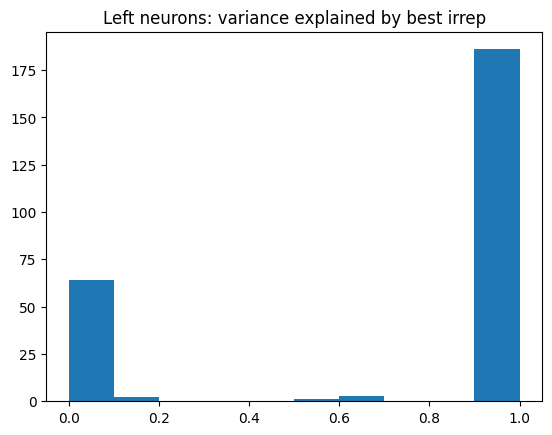

In [18]:
plt.hist(lexpl_max.tolist())
plt.title('Left neurons: variance explained by best irrep')
plt.show()

Because 4d-0 and 4d-1 are real irreps and so do not obey Schur orthogonality, there is ambiguity in the $A_i,B_i,C_i$ coefficients.

Thus, for simplicity, let's look at 4d-2 first.

In [38]:
lneurons.shape

torch.Size([120, 256])

In [49]:
irrep_idxs = [
    i for i in range(lneurons.shape[-1]) 
    if lexpl['4d-2'][i].item() > 0.9999 and lneurons[:,i].norm() > 1e-4
]
print(len(irrep_idxs))
irrep_lneurons = lneurons[:, irrep_idxs]
irrep_rneurons = rneurons[:, irrep_idxs]
irrep_uneurons = uneurons[:, irrep_idxs]
irrep = irreps['4d-2']

51


In [51]:
flat_irrep = einops.rearrange(irrep, 'n d1 d2 -> n (d1 d2)')
# Project neurons onto subspace spanned by flat_irrep
A_flat = (t.linalg.inv(flat_irrep.T @ flat_irrep) @ flat_irrep.T @ irrep_lneurons)
B_flat = (t.linalg.inv(flat_irrep.T @ flat_irrep) @ flat_irrep.T @ irrep_rneurons)
C_flat = (t.linalg.inv(flat_irrep.T @ flat_irrep) @ flat_irrep.T @ irrep_uneurons)
A = einops.rearrange(A_flat, '(d1 d2) m -> m d1 d2', d1=4, d2=4).mT
B = einops.rearrange(B_flat, '(d1 d2) m -> m d1 d2', d1=4, d2=4).mT
C = einops.rearrange(C_flat, '(d1 d2) m -> m d1 d2', d1=4, d2=4).mT
A.shape, B.shape, C.shape

(torch.Size([51, 4, 4]), torch.Size([51, 4, 4]), torch.Size([51, 4, 4]))

### Observation 1: $C_i\approx A_iB_i$

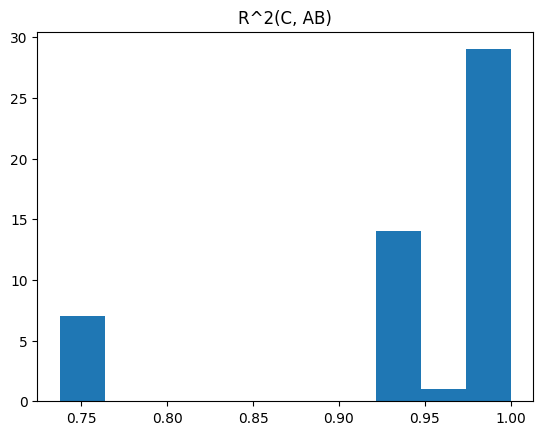

In [58]:
x = einops.rearrange(A @ B, 'm d1 d2 -> m (d1 d2)')
y = einops.rearrange(C, 'm d1 d2 -> m (d1 d2)')
coef = (x * y).sum(dim=-1) / (x * x).sum(dim=-1)
yhat = coef.unsqueeze(1) * x
r2 = (yhat - y).norm(dim=-1).pow(2) / y.norm(dim=-1).pow(2)
plt.hist(r2.tolist())
plt.title('R^2(C, AB)')
plt.show()

### Observation 2: $A_i, B_i, C_i$ are almost rank 1

Thus, we can write
$$A_i\approx a_ib_i^\top$$
$$B_i\approx c_id_i^\top$$
$$C_i\approx A_iB_i\approx \langle b_i, c_i\rangle a_i d_i^\top$$

In [124]:
a, b, c, d, A_expl, B_expl = [], [], [], [], [], []
for i in range(len(irrep_idxs)):
    lu, ls, lv = t.svd(A[i])
    ru, rs, rv = t.svd(B[i])
    a.append(lu[:,0])
    b.append(lv[0])
    c.append(ru[:,0])
    d.append(rv[0])
    A_expl.append(ls[0].pow(2) / ls.pow(2).sum())
    B_expl.append(rs[0].pow(2) / rs.pow(2).sum())
a, b, c, d = t.stack(a, dim=0), t.stack(b, dim=0), t.stack(c, dim=0), t.stack(d, dim=0)
min(A_expl), min(B_expl)

(tensor(1.0000), tensor(1.0000))

### Observation 3: $a_i$ is constant and $c_i$ are clustered

In [125]:
a_mean = a.mean(dim=0)
(a - a_mean).norm() / a.norm()

tensor(0.0006)

In [126]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5).fit(c.numpy())
print(-kmeans.score(c.numpy()))
c_mean = t.tensor(kmeans.cluster_centers_)
c_mean.shape

0.0003687285352498293


torch.Size([5, 4])

In [127]:
corr = c_mean @ c_mean.T
corr

tensor([[ 1.0000,  0.2494,  0.2507, -0.2499, -0.2496],
        [ 0.2494,  1.0000, -0.2530,  0.2492,  0.2508],
        [ 0.2507, -0.2530,  1.0000,  0.2492,  0.2475],
        [-0.2499,  0.2492,  0.2492,  1.0000, -0.2505],
        [-0.2496,  0.2508,  0.2475, -0.2505,  1.0000]])

**Note:** 5 unit vectors evenly spaced in 4 dimensions will all have pairwise inner product = -1/4.

The +1/4 inner products above are due to ambiguity in the sign of singular vectors.

Let's transform the $c_i$ and $d_i$ to make everything -1/4

In [128]:
sign_mean = t.tensor(
    [1.] + t.sign(-corr[0,1:]).tolist()
)
t.diag(sign_mean) @ c_mean @ c_mean.T @ t.diag(sign_mean)

tensor([[ 1.0000, -0.2494, -0.2507, -0.2499, -0.2496],
        [-0.2494,  1.0000, -0.2530, -0.2492, -0.2508],
        [-0.2507, -0.2530,  1.0000, -0.2492, -0.2475],
        [-0.2499, -0.2492, -0.2492,  1.0000, -0.2505],
        [-0.2496, -0.2508, -0.2475, -0.2505,  1.0000]])

In [129]:
sign = t.zeros(c.shape[0])
for i in range(c.shape[0]):
    sign[i] = sign_mean[kmeans.labels_[i]]
c = t.diag(sign) @ c
d = t.diag(sign) @ d
kmeans = KMeans(n_clusters=5).fit(c.numpy())
print(-kmeans.score(c.numpy()))
c_mean = t.tensor(kmeans.cluster_centers_)
c_mean.shape
corr = c_mean @ c_mean.T
corr

0.0003687285352498293


tensor([[ 1.0000, -0.2492, -0.2530, -0.2507, -0.2475],
        [-0.2492,  1.0000, -0.2492, -0.2499, -0.2505],
        [-0.2530, -0.2492,  1.0000, -0.2494, -0.2508],
        [-0.2507, -0.2499, -0.2494,  1.0000, -0.2496],
        [-0.2475, -0.2505, -0.2508, -0.2496,  1.0000]])